# Project Setup
---
##### Description of the problem
The goal is to transform images in the style of Claude Monet using Generative Adversarial Networks (GANs). We need to create a system that can transform regular photos into images that look like Monet's painting style. A challenge in this task is maintaining realism while also embedding his style.


##### What is a GAN?
Generative Adversarial Networks (GANs) are a class of machine learning models where two networks (Generator and a Discriminator) exist. The Generator creates the transformations from the input images and the Discriminator evaluates authenticity. After many epochs of training, the Generator will be able to trick the Discriminator into believing the output images are real, indicating our generator is performing well.

##### Description of the data
The dataset includes two folders:

- Photos: A set of realistic images representing the real-world settings.
- Monet Paintings: A collection of images in Monet’s artistic style. This is the target style.

---

In [17]:
import shutil
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import time
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Exploratory Data Analysis
---
1. Visualized Sample Images
    - Displayed sample images from the Monet dataset and the photo dataset.
    - Monet's paintings show brushstrokes, color blends, and an artistic feel.
    - The real photos have sharp details and realistic lighting and textures.

2. Printed Dataset Sizes
    - Monet Dataset: 300 images.
    - Photo Dataset: 7038 images.
    - The larger size of the photo dataset means we need to balance during training.

3. Analyzed Image Properties
    - All images are already in 256x256 dimensions and RGB mode.
    - The uniform size and format simplify preprocessing, as no resizing or color channel adjustments are needed.

4. Pixel Value Distribution
    - Generated color histograms to analyze pixel value distributions across the RGB channels.
    - Monet images have smooth, bell-shaped distributions for all three color channels.
    - Monet's color distributions reflect blending of colors, while photos show the sharp transitions of color.

---

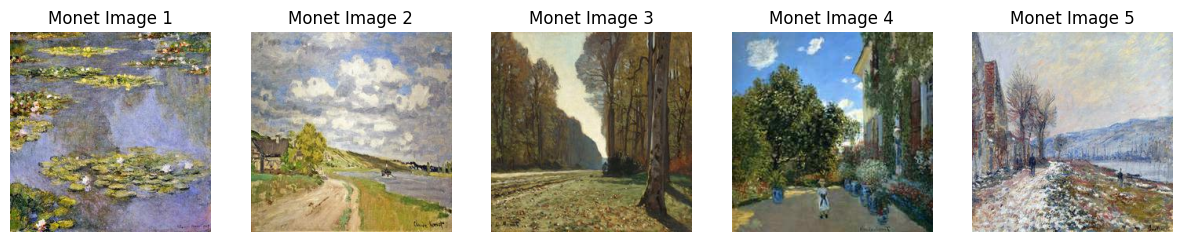

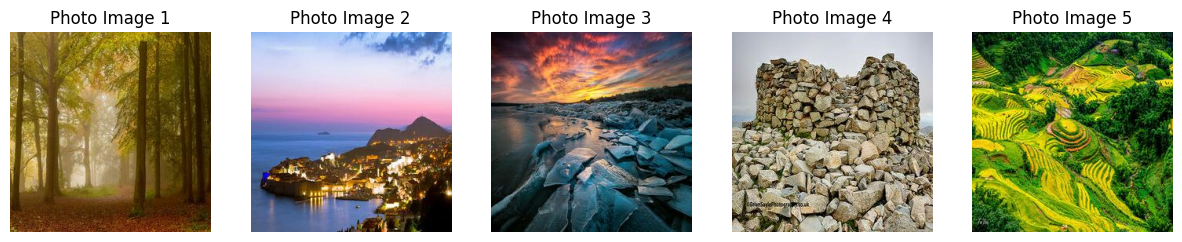

Number of Monet images: 300
Number of Photo images: 7038
Image size: (256, 256), Mode: RGB


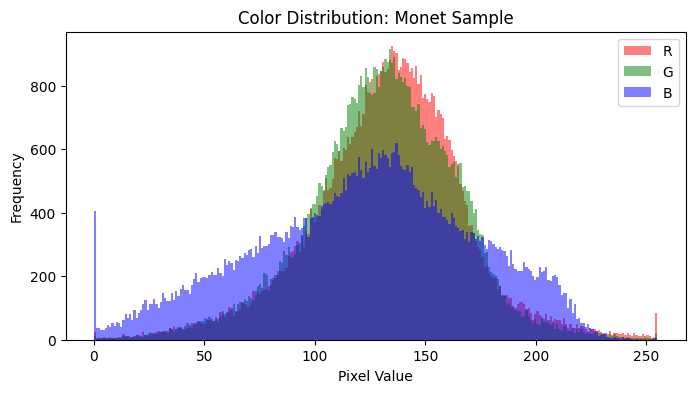

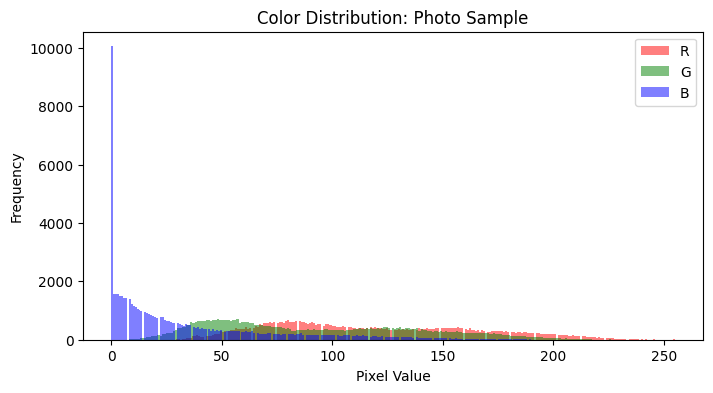

In [18]:
#########################
# Display Sample Images #
#########################
monet_path = '/kaggle/input/gan-getting-started/monet_jpg'
photo_path = '/kaggle/input/gan-getting-started/photo_jpg'
monet_files = os.listdir(monet_path)
photo_files = os.listdir(photo_path)

def display_images(img_folder, img_list, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(img_list[:num_samples]):
        img = Image.open(os.path.join(img_folder, img_name))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {i + 1}")
    plt.show()

display_images(monet_path, monet_files, 'Monet Image')
display_images(photo_path, photo_files, 'Photo Image')


#########################
# Total Number of files #
#########################
print(f"Number of Monet images: {len(monet_files)}")
print(f"Number of Photo images: {len(photo_files)}")


###########################
# Check Image Size & Mode #
###########################
sample_img = Image.open(os.path.join(monet_path, monet_files[0]))
print(f"Image size: {sample_img.size}, Mode: {sample_img.mode}")


###############################
# Pixel Distribution for each #
###############################
def plot_color_histogram(image_path, title):
    img = Image.open(image_path).convert('RGB')
    img_array = np.array(img)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        plt.hist(img_array[:, :, i].flatten(), bins=256, color=color, alpha=0.5, label=f'{color.upper()}')
    plt.title(f'Color Distribution: {title}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

plot_color_histogram(os.path.join(monet_path, monet_files[0]), "Monet Sample")
plot_color_histogram(os.path.join(photo_path, photo_files[0]), "Photo Sample")

# Model Architecture
---
##### Plan based on EDA
Some key observations were made during the exploratory data analysis phase. There are 300 training (Monet) images and 7038 input (photo) images.  Each are already sized appropriately at 256x256 and in RGB formatting.  This simplifies the preprocessing step by lessening the steps needed to take. The color distributions in the Monet images are smooth, bell-shaped distributions.  There is a spike in blue pixels at 0 pixel value (also the case for the input photos).  The input photos have a peak in blue at lower pixel values with a more smooth, almost uniform distribution for green and red.  This indicates a stark difference in image styles considering the actual image subjects are similar.

##### Architecure Overview
1. Preprocess the Monet images
    - Normalize Images
    - Create datasets 
3. Model
    - Use a CycleGAN model since the images are not paired.
    - The model architecture includes:
        - Two generators: One to map photos → Monet and another to map Monet → photos.
        - Two discriminators: One for distinguishing real Monet images from generated ones and another for photos.
    - Loss Functions
        - Adversarial Loss: To ensure realism
        - Cycle Consistency Loss: To preserve content during style transformations
        - Identity Loss: To Improve Generator Stability
    - Optimization: Generators and discriminators trained alternately with Adam optimizers.

---

In [19]:
##########################
# LOAD DATA ##############
##########################
monet_path = "/kaggle/input/gan-getting-started/monet_jpg"
photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

class img_df(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [
            os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.jpg')
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

monet_dataset = img_df(directory=monet_path, transform=image_transforms)
photo_dataset = img_df(directory=photos_path, transform=image_transforms)
monet_loader = DataLoader(monet_dataset, batch_size=4, shuffle=True, num_workers=4)
photo_loader = DataLoader(photo_dataset, batch_size=4, shuffle=True, num_workers=4)

###########################
# Generators ##############
###########################
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(256) for _ in range(6)]
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, output_channels, kernel_size=7, stride=1, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.res_blocks(x)
        x = self.decoder(x)
        return x

compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Generator_AtoB = Generator(input_channels=3, output_channels=3).to(compute_device)
Generator_BtoA = Generator(input_channels=3, output_channels=3).to(compute_device)



###########################
# Discriminators ##########
###########################
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.layers = nn.Sequential(
            self._disc_block(input_channels, 64, normalization=False),
            self._disc_block(64, 128),
            self._disc_block(128, 256),
            self._disc_block(256, 512, stride=1),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)  # Final layer for output score
        )

    @staticmethod
    def _disc_block(in_channels, out_channels, stride=2, normalization=True):
        """A helper function to define a block for the discriminator."""
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1)]
        if normalization:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Discriminator_A = Discriminator(input_channels=3).to(compute_device)
Discriminator_B = Discriminator(input_channels=3).to(compute_device)

##############
# Optimizers #
##############

adversarial_loss = nn.MSELoss()
cycle_consistency_loss = nn.L1Loss()
identity_mapping_loss = nn.L1Loss()

gen_optimizer = optim.Adam(
    list(Generator_AtoB.parameters()) + list(Generator_BtoA.parameters()),
    lr=0.0002,
    betas=(0.5, 0.999)
)

disc_optimizer_A = optim.Adam(
    Discriminator_A.parameters(), 
    lr=0.0002, 
    betas=(0.5, 0.999)
)

disc_optimizer_B = optim.Adam(
    Discriminator_B.parameters(), 
    lr=0.0002, 
    betas=(0.5, 0.999)
)


#################
# Training loop #
#################

epochs = 100
losses = defaultdict(list)

start_time = time.process_time()

for epoch in range(epochs):
    epoch_start = time.process_time()

    for idx, (data_A, data_B) in enumerate(zip(photo_loader, monet_loader)):
        inputs_A = data_A.to(compute_device)
        inputs_B = data_B.to(compute_device)

        gen_optimizer.zero_grad()

        generated_B = Generator_AtoB(inputs_A)
        fake_B_preds = Discriminator_B(generated_B)
        loss_G_AtoB = adversarial_loss(fake_B_preds, torch.ones_like(fake_B_preds))

        generated_A = Generator_BtoA(inputs_B)
        fake_A_preds = Discriminator_A(generated_A)
        loss_G_BtoA = adversarial_loss(fake_A_preds, torch.ones_like(fake_A_preds))

        rec_A = Generator_BtoA(generated_B)
        cycle_loss_A = cycle_consistency_loss(rec_A, inputs_A)

        rec_B = Generator_AtoB(generated_A)
        cycle_loss_B = cycle_consistency_loss(rec_B, inputs_B)

        id_loss_A = identity_mapping_loss(Generator_BtoA(inputs_A), inputs_A)
        id_loss_B = identity_mapping_loss(Generator_AtoB(inputs_B), inputs_B)

        total_gen_loss = (
            loss_G_AtoB + loss_G_BtoA +
            10.0 * (cycle_loss_A + cycle_loss_B) +
            5.0 * (id_loss_A + id_loss_B)
        )
        total_gen_loss.backward()
        gen_optimizer.step()

        disc_optimizer_A.zero_grad()
        real_A_preds = Discriminator_A(inputs_A)
        real_loss_A = adversarial_loss(real_A_preds, torch.ones_like(real_A_preds))

        fake_A_preds = Discriminator_A(generated_A.detach())
        fake_loss_A = adversarial_loss(fake_A_preds, torch.zeros_like(fake_A_preds))

        disc_A_loss = (real_loss_A + fake_loss_A) * 0.5
        disc_A_loss.backward()
        disc_optimizer_A.step()

        disc_optimizer_B.zero_grad()
        real_B_preds = Discriminator_B(inputs_B)
        real_loss_B = adversarial_loss(real_B_preds, torch.ones_like(real_B_preds))

        fake_B_preds = Discriminator_B(generated_B.detach())
        fake_loss_B = adversarial_loss(fake_B_preds, torch.zeros_like(fake_B_preds))

        disc_B_loss = (real_loss_B + fake_loss_B) * 0.5
        disc_B_loss.backward()
        disc_optimizer_B.step()

        losses['generator'].append(total_gen_loss.item())
        losses['disc_A'].append(disc_A_loss.item())
        losses['disc_B'].append(disc_B_loss.item())

        if idx % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Batch {idx}: "
                  f"Gen Loss: {total_gen_loss.item()}, Disc A Loss: {disc_A_loss.item()}, Disc B Loss: {disc_B_loss.item()}")

    epoch_end = time.process_time()
    print(f"Epoch {epoch+1} finished in {epoch_end - epoch_start:.2f}s")

total_end = time.process_time()
print(f"Total training time: {total_end - start_time:.2f}s")

torch.save(Generator_AtoB.state_dict(), 'Generator_AtoB.pth')
torch.save(Generator_BtoA.state_dict(), 'Generator_BtoA.pth')

Epoch 1/100, Batch 0: Gen Loss: 18.630657196044922, Disc A Loss: 0.6875735521316528, Disc B Loss: 0.6044251918792725
Epoch 1/100, Batch 50: Gen Loss: 6.693025588989258, Disc A Loss: 0.27312421798706055, Disc B Loss: 0.2851372957229614
Epoch 1 finished in 109.75s
Epoch 2/100, Batch 0: Gen Loss: 5.812738418579102, Disc A Loss: 0.4635222554206848, Disc B Loss: 0.2692130506038666
Epoch 2/100, Batch 50: Gen Loss: 5.661900043487549, Disc A Loss: 0.2181713581085205, Disc B Loss: 0.2643563747406006
Epoch 2 finished in 110.20s
Epoch 3/100, Batch 0: Gen Loss: 6.797701358795166, Disc A Loss: 0.198486328125, Disc B Loss: 0.26030996441841125
Epoch 3/100, Batch 50: Gen Loss: 6.532884120941162, Disc A Loss: 0.26270827651023865, Disc B Loss: 0.2504841685295105
Epoch 3 finished in 110.26s
Epoch 4/100, Batch 0: Gen Loss: 4.861485481262207, Disc A Loss: 0.20203205943107605, Disc B Loss: 0.24493202567100525
Epoch 4/100, Batch 50: Gen Loss: 7.120400905609131, Disc A Loss: 0.21041926741600037, Disc B Loss: 

# Results
---
### 1. Visual Inspection
   - Can see a change in the right direction.
### 2. Loss Over Epoch Plot
   - Generator Loss
     - The generator loss started out pretty high which indicates it was not tricking the discriminators. It tapered down over time showing improvement as training went on. It stabilized at about 30 epochs but still gradually lowered throughout training.
   - Discriminator Loss
     - The discriminator loss maintained a low level indicating it was effective at discenrning real vs fake.
    
### 3. Overall
   - The stablility of the charts is a good sign, indicating there is not an issue with overfitting.  The convergence was still continuing as well.  These two factors indicate we might have better performance if we let the model train for even longer (just difficult to do when our usage is throttled).
---

Execution Time: 157.93 seconds


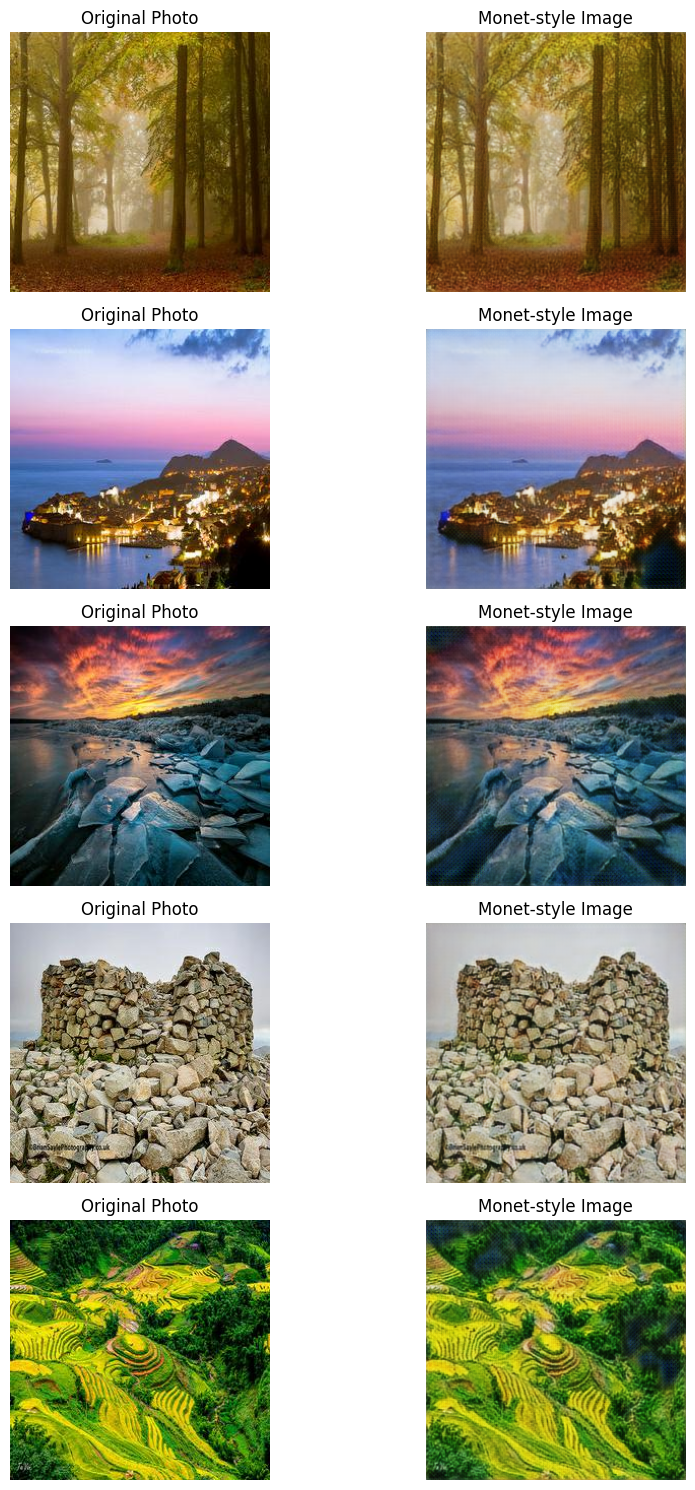

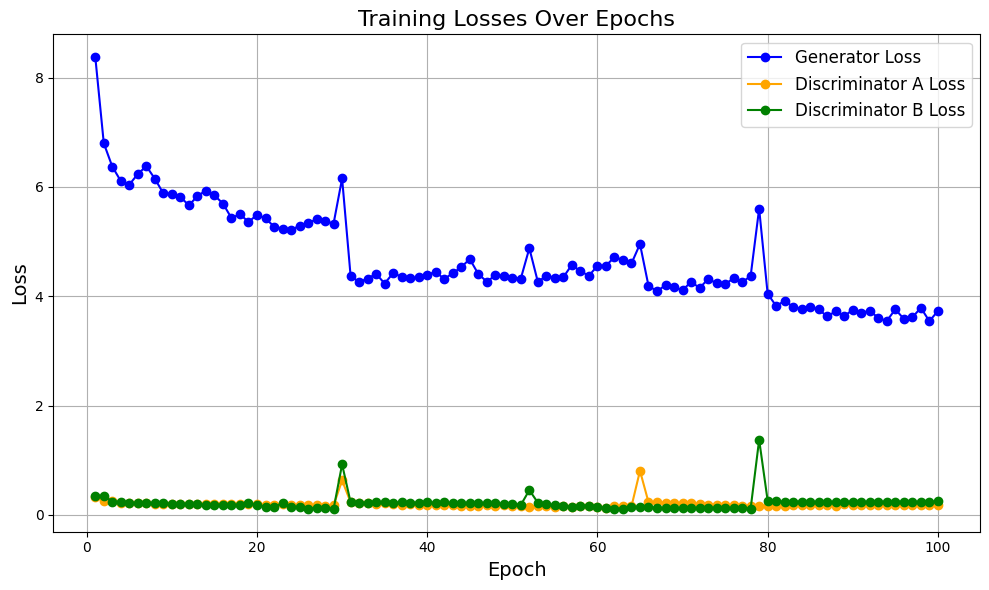

In [20]:
###########################
# Load and process images #
###########################

photos_path = "/kaggle/input/gan-getting-started/photo_jpg"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

photo_filenames = [f for f in os.listdir(photos_path) if f.endswith('.jpg')]
photos = [transform(Image.open(os.path.join(photos_path, filename)).convert('RGB')) for filename in photo_filenames]
photos = torch.stack(photos)


###############################
# Generate Monet-style images #
###############################

Generator_AtoB = Generator(input_channels=3, output_channels=3).to(compute_device)
Generator_AtoB.load_state_dict(torch.load('/kaggle/working/Generator_AtoB.pth', map_location=compute_device, weights_only=True))
Generator_AtoB.eval()

start_time = time.time()

output_dir = '/images'
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for i, photo in enumerate(photos):
        photo = photo.unsqueeze(0).to(compute_device)
        monet_style_image = Generator_AtoB(photo).squeeze(0).cpu()
        monet_style_image = transforms.ToPILImage()(monet_style_image * 0.5 + 0.5)
        monet_style_image.save(os.path.join(output_dir, f'monet_style_{i+1}.jpg'))

shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

elapsed_time = time.time() - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")


######################################
# Show example image transformations #
######################################

num_examples = 5
fig, axes = plt.subplots(num_examples, 2, figsize=(10, 15))

for i in range(num_examples):
    photo = photos[i].unsqueeze(0).to(compute_device)
    monet_style_image = Generator_AtoB(photo).squeeze(0).cpu()
    monet_style_image = transforms.ToPILImage()(monet_style_image * 0.5 + 0.5)
    
    # Original photo
    axes[i, 0].imshow(transforms.ToPILImage()(photos[i] * 0.5 + 0.5))
    axes[i, 0].set_title("Original Photo")
    axes[i, 0].axis('off')
    
    # Monet-style transformation
    axes[i, 1].imshow(monet_style_image)
    axes[i, 1].set_title("Monet-style Image")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


############################
# Plot aggregate loss for each epoch #
############################

generator_losses = np.array(losses['generator']).reshape(epochs, -1).mean(axis=1)
disc_A_losses = np.array(losses['disc_A']).reshape(epochs, -1).mean(axis=1)
disc_B_losses = np.array(losses['disc_B']).reshape(epochs, -1).mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), generator_losses, label='Generator Loss', color='blue', marker='o')
plt.plot(range(1, epochs + 1), disc_A_losses, label='Discriminator A Loss', color='orange', marker='o')
plt.plot(range(1, epochs + 1), disc_B_losses, label='Discriminator B Loss', color='green', marker='o')

plt.title('Training Losses Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Conclusion
---
### First Pass
I ultimately scored a 72.  Looking at the output it was a little fuzzy when comparing the trasnformed images to the original vs what the actual Monet paintings looked like.  I suspect I might have gotten better performance if I increased my epoch count from 25 to a much higher value.  I ultimately stuck with a lower value since we are capped on how much GPU allocation we get and development can take quite a bit of it.  The loss scores seemed to plateau after about 10 epochs but I remain suspicious that I could improve the model with more epochs. I may try it for fun once my utilization resets.

### Second Pass
I increased the epoch count to 100 and showed an increase in performance.  The visual inspection looked slightly better but still not how I would like.  The loss plot was promising however, showing stability and convergence.  As mentioned above, I believe if trained for even longer, we would see further convergence and maybe even an improvement in the visual inspection.

---
